# Pokemon Quantum fight

## Table of Contents

* [Chap 0 : Prerequisite](#chap0)
* [Idea behind](#idea)
* [The game](#game)
    * [General processes](#general_process)
* [Artificial Intelligence](#ai)
    * [Strategy](#strategy)
    * [Grover's algorithm](#grover)
    * [Qram](#qram)
    * [General algorythm](#algorythm)
* [And now ?](#then)
* [References](#references)

## Chap 0 : Prerequisite <a class="anchor" id="chap0"></a>
Before starting, we need to have qiskit install, for that we just need to execute the following cell :

In [209]:
pip install qiskit
pip install qiskit[visualization]
#pip install 'qiskit[visualization]'
pip install numpy
pip install matplotlib

SyntaxError: invalid syntax (<ipython-input-209-05dd3b7c3373>, line 1)

To test your installation :

In [2]:
import math
from random import *
from IPython.display import Image, display, YouTubeVideo
import numpy as np
import qiskit
from qiskit import Aer, QuantumCircuit, execute, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}

In order to initialize our quantum computer just run the following cell :

In [ ]:
# Init Qasm simulator backend
qasm = Aer.get_backend('qasm_simulator')

# Init Real Quantum computer
# If you run qiskit on a real computer for the first you will need to create an account on https://quantum-computing.ibm.com/login
# and run the following line with you token.
#IBMQ.save_account('MY_API_TOKEN')

IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quantum_computer = provider.get_backend('ibmq_16_melbourne')

# Here we will use the local simulator --> Aer
backend_sim = qasm  # Choose your backend : <quantum_computer> or <qasm>

## Idea behind <a class="anchor" id="idea"></a>
The main idea of this program came from the Nostalgie, if you borned between 90 and 95 you certainly played to the first Pokemon games Red and Blue (not you Yellow) and of course you remebered the opening of the game :

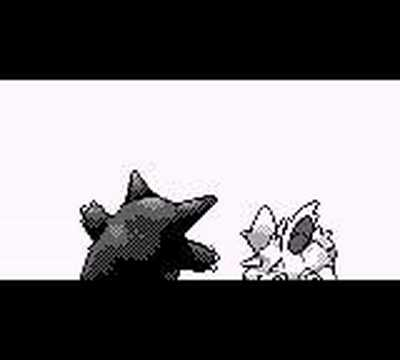

In [210]:
YouTubeVideo('C19O5xm51dk')

That this first fight who gave me the idea of doing this program but with a quantumification of every processes and a possibility to give to the opposent a quantum (kind of) AI.
Here in this article, I'll not go deep in the classical frame but mainly in the quantum processes. 

## The game <a class="anchor" id="game"></a>
The structure of the game is doing in classical python programming and can resume by :
- init of the objects
    - choice of quantum backend
    - types
    - attacks
    - pokemon
    - players
- fight
    - team creation
    - choice of action -> attack or switch (quantum)
        - if attack -> choice of attack (quantum)
        - if switch -> choice of pokemon switch (quantum)
    - choice of who attack first by the level of speed
    - choice if speed of both pokemon are the same (quantum)
    - precision of the attack (quantum)
    - critical attack (quantum)
    - malus apply -> poison / paralysie / burn / freeze (quantum)
    - choice of next pokemon if ai pokemon is ko (quantum)

To resume every probability calcul and opposent choice are doing by a quantum process. The perfect structure could be resume by :

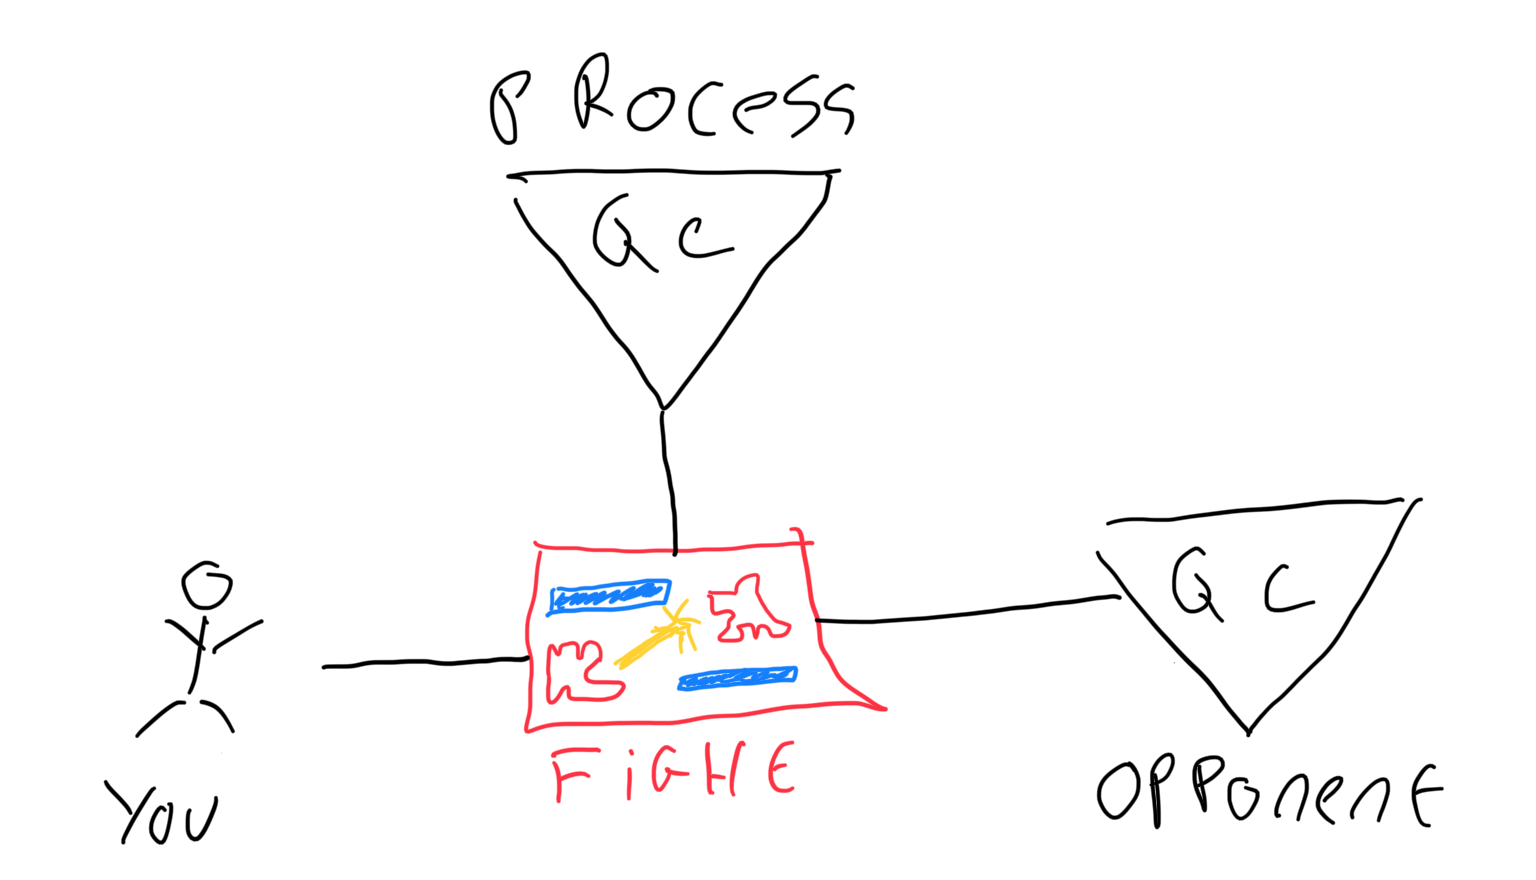

In [211]:
Image("images_jupyter/structure.png", width="700")

### General processes <a class="anchor" id="general_process"></a>
As shown in my schema upper I use the same quantum computer for every of my probabilities processes and as the only difference between these calculations are only the probability of happening I just use the same circuit but with an angle of theta different.

#### Precision / Critical / Status malus / Speed draw
- When a pokemon declare an attack, the first thing to do is checking if the attack can touch the opposent, this is doing by doing a check the accuracy of the move. We call this number $\psi$ (say $psi$) then I'm creating a qubit and apply a quantum gate of $\pi*\psi$.
If the accuracy is $100\%$ so my qubit are going to pass from 0 to 1 means the attack is touching the target. If the attack has an accurancy of $70\%$, the qubit will be in superposition and its the role of the measurement to "choose" if the qubit will collapse for the state 0 or go to 1.


- Then the next thing to check is the probability of critical, except some exception this number is always the same approximatly $4\%$ ($4.17\%$). With this number we'll apply him the same transformation are the accuracy one.


- Finally we check if the move is a fire, poison, electrik or ice move if so, we apply to a qubit a transformation of the respective accuracy ($10\%$, $30\%$, $30\%$ and $10\%$) and see if the a malus of burn, poison, paralysis or freeze will apply.


- Most of the time, the order of which pokemon move first are by the level of their speed but sometimes both have the same speed in this case, we put a qubit in the perfect superposition $\frac{\pi}{2}$

In [4]:
attack = 0.7 # Accuracy of the attack, most of the attacks are a precision of 100%, 90% or 70%
crit = 0.0417 # Critical 
burn = 0.1
poison = 0.3
para = 0.3
freeze = 0.1
speedtie = 0.5

qc = QuantumCircuit(1, 1)

qc.rx(math.pi * attack, 0) # The gate RX is a NOT gate who allow us to define the theta angle
qc.measure(0, 0)

qc.draw()

┌────────────┐┌─┐
q_0: ┤ RX(7pi/10) ├┤M├
     └────────────┘└╥┘
c: 1/═══════════════╩═
                    0

Now we have our circuit, run the following cell to read the result and see if the attack touch the opposent.

In [213]:
job = execute(qc, backend_sim, shots=1, memory=True)
result_job = job.result().get_memory()
to_return = int(result_job[0], 2)
if to_return == 1:
    print("Result : {}, the attack succeed !".format(to_return))
else:
    print("Result : {}, the attack miss the target !".format(to_return))

Result : 1, the attack succeed !


As you can see, most of the time the result is switching from 0 to 1 but sometimes the superposition collapse to 0 instead.

## Artificial Intelligence <a class="anchor" id="ai"></a>
Here comes the main part of the program, the real challenge, how to program the quantum computer opposent to be a good challenger to you !?!? 
We'll try to make something "simple" so we'll not program some fancy neural network to make the computer better and better but we "just" making its knowing the basic rules of each of us alrealdy know :
- type mapping
- switching or attacking

### Strategy <a class="anchor" id="strategy"></a>
To program our quantum brain, here a fast reminder of the Pokemon strategy. Every type have their weikness and their resistances when a Pokemon is touching by a move from its weikness it took the double damages and when it's touching by a movre from its resistance it took the half less of damages.
The entire type mapping are available here : https://boutique-pokemon.com/blogs/blog-pokemon/table-types-pokemon (french version).

They are different ways to program it, I choose to use the Vertex Cover algorithm. The principe of this algorithm is to map everything in a graph. More information about this algorithm here : https://en.wikipedia.org/wiki/Vertex_cover

That'll allow us to make our types to interact with each other in something like that :

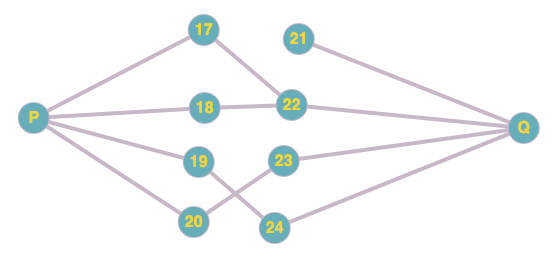

In [214]:
Image("images_jupyter/types_graph.png", width="500")

Here the alphabetical vertex are the both fighter and the number vertex are the type of the move are type weakness of the fighter at right. This graph is the key to program every of the actions of our quantum computer. With this graph in mind, it'll attack with the strongest move or switch if its fighter is in disadvange.

#### Quantumification
Now we have a basic graph, how can we translate it to quantum computing ? We need to have a structure who give us most of the time the best answer. Finding a structure who can have every of the inputs possible and correct itself to give us the correct output no matter what ! Here comes the Grover algorithm...

### Grover's algorithm <a class="anchor" id="grover"></a>
You may already hearded that one of the many advange of quantum computer is the database searching speed. Indeed that's the role of the Grover's algorithm. Is'nt its only role, indeed it also used for classical algorithm subroutine as game resolution or other.

#### Resume
Grover's algorithm is using the amplitude amplification to correct itself. Grover use several inputs and with a diffuser amplify the inouts who match with the oracle to give the output. 

Example :

In [215]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)
    qc.h(nqubits - 1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "$Diff$"
    return U_s

algo = QuantumRegister(3, 'algo')
oracle = QuantumRegister(1, 'oracle')
c = ClassicalRegister(3, 'measurement')
qc = QuantumCircuit(algo, oracle, c)

qc.append(diffuser(3), [0, 1, 2])

qc.draw()
algo = QuantumRegister(3, 'algo')
oracle = QuantumRegister(1, 'oracle')
c = ClassicalRegister(3, 'measurement')
qc = QuantumCircuit(algo, oracle, c)

# Init
qc.h(algo)
qc.x(oracle)
qc.h(oracle)
qc.barrier()

# Algorithm
qc.mcx(algo, oracle)
qc.barrier()

# Diffuser
qc.append(diffuser(3), [0, 1, 2])

# Measure of the ouputs
qc.barrier()
qc.measure(algo, c)

qc.draw()

┌───┐      ░       ░ ┌─────────┐ ░ ┌─┐      
       algo_0: ┤ H ├──────░───■───░─┤0        ├─░─┤M├──────
               ├───┤      ░   │   ░ │         │ ░ └╥┘┌─┐   
       algo_1: ┤ H ├──────░───■───░─┤1 $Diff$ ├─░──╫─┤M├───
               ├───┤      ░   │   ░ │         │ ░  ║ └╥┘┌─┐
       algo_2: ┤ H ├──────░───■───░─┤2        ├─░──╫──╫─┤M├
               ├───┤┌───┐ ░ ┌─┴─┐ ░ └─────────┘ ░  ║  ║ └╥┘
     oracle_0: ┤ X ├┤ H ├─░─┤ X ├─░─────────────░──╫──╫──╫─
               └───┘└───┘ ░ └───┘ ░             ░  ║  ║  ║ 
measurement: 3/════════════════════════════════════╩══╩══╩═
                                                   0  1  2

- The inputs are represented by the qubits "algo_" at the left
- The algorithm is represented by the CNOT gate in the middle
- The diffuseur is represented by the big block at the end
- The oracle is out last qubit, it's in superposition $|->$ to inverse the phase of the inputs who match gate.

Here all our inputs are in superposition with each others so we have something like : $\frac{|000> + |001> + |010> + ... |111>}{\sqrt{8}}$.
<br/>Then our algorithm is only an MCT gate and will be activate only if all the qubits are in the state 1, means only the inputs $|111>$ will interact with the oracle so the phase of this inputs will tend to $|->$.
<br/>Finally our diffuser is going to read all of the inputs and if it see an inputs with a negative phase it'll amplify this input to $3 * \theta$ (or $2 * \theta$ regards to its initial amplitude).

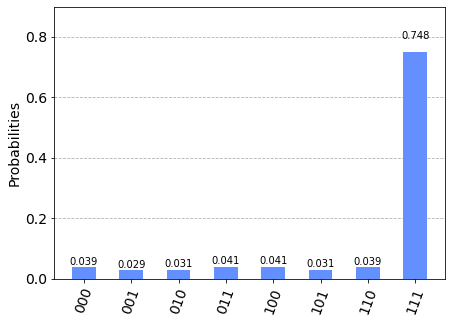

In [216]:
job = execute(qc, backend_sim, shots=512)
result_job = job.result()
plot_histogram(result_job.get_counts())

Here our results, most of the time the answer is our predictive answer.

More information about Grover here :

### Qram <a class="anchor" id="qram"></a>
First thing first, how can we pass our inputs to grover ? In the upper general example of using grover we gave its 3 random qubits, but we want to give its our list of attacks or the type of our fighter instead. To do that, we'll use the QRAM (Quantum Random Access Memory), like classical RAM it'll allow us to map every input we want.

#### Attacks
To give an example of Qram we'll map all of the attack move type of our fighter :

In [217]:
# We have our Tortank with 4 attacks : hydroblast, earthquake, ice beam, giga-impact
# We want to map every of our attack to their respective type like : 
# [hydroblast : water, earthquake : ground , ice beam : ice , giga-impact : normal]

# Init register 
qram_q = QuantumRegister(2, 'qram') # We have 4 elements to map to 2 qubits are enough
normal_q = QuantumRegister(1, 'normal')
fire_q = QuantumRegister(1, 'fire')
grass_q = QuantumRegister(1, 'grass')
ground_q = QuantumRegister(1, 'ground')
fly_q = QuantumRegister(1, 'fly')
water_q = QuantumRegister(1, 'water')
elec_q = QuantumRegister(1, 'electrick')
ice_q = QuantumRegister(1, 'ice')
bug_q = QuantumRegister(1, 'bug')
steel_q = QuantumRegister(1, 'steel')
qc_init = QuantumCircuit(qram_q)

# Init qubits
qc_init.h(qram_q) # Init our inputs to superposition
#qc.barrier()

qc_qram = QuantumCircuit(qram_q, normal_q, fire_q, grass_q, ground_q, fly_q, water_q, elec_q, ice_q, bug_q, steel_q, c)

# Mapping attacks
## First attack is going to be on the address 00
qc_qram.x(qram_q)
qc_qram.ccx(qram_q[0], qram_q[1], water_q)
qc_qram.x(qram_q)
qc_qram.barrier()
## Second attack -> 01
qc_qram.x(qram_q[0])
qc_qram.ccx(qram_q[0], qram_q[1], ground_q)
qc_qram.x(qram_q[0])
qc_qram.barrier()
## Third attack -> 10
qc_qram.x(qram_q[1])
qc_qram.ccx(qram_q[0], qram_q[1], ice_q)
qc_qram.x(qram_q[1])
qc_qram.barrier()
## Fourth attack -> 11
qc_qram.ccx(qram_q[0], qram_q[1], normal_q)
qc_qram.barrier()

qc_initQram = qc_init + qc_qram
qc_initQram.draw()

┌───┐┌───┐     ┌───┐ ░ ┌───┐     ┌───┐ ░                 ░      »
       qram_0: ┤ H ├┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├─░────────■────────░───■──»
               ├───┤├───┤  │  ├───┤ ░ └───┘  │  └───┘ ░ ┌───┐  │  ┌───┐ ░   │  »
       qram_1: ┤ H ├┤ X ├──■──┤ X ├─░────────■────────░─┤ X ├──■──┤ X ├─░───■──»
               └───┘└───┘  │  └───┘ ░        │        ░ └───┘  │  └───┘ ░ ┌─┴─┐»
     normal_0: ────────────┼────────░────────┼────────░────────┼────────░─┤ X ├»
                           │        ░        │        ░        │        ░ └───┘»
       fire_0: ────────────┼────────░────────┼────────░────────┼────────░──────»
                           │        ░        │        ░        │        ░      »
      grass_0: ────────────┼────────░────────┼────────░────────┼────────░──────»
                           │        ░      ┌─┴─┐      ░        │        ░      »
     ground_0: ────────────┼────────░──────┤ X ├──────░────────┼────────░──────»
                           │        ░      └───┘      ░        │        ░      »
        fly_0: ────────────┼────────░─────────────────░────────┼────────░──────»
                         ┌─┴─┐      ░                 ░        │        ░      »
      water_0: ──────────┤ X ├──────░─────────────────░────────┼────────░──────»
                         └───┘      ░                 ░        │        ░      »
  electrick_0: ─────────────────────░─────────────────░────────┼────────░──────»
                                    ░                 ░      ┌─┴─┐      ░      »
        ice_0: ─────────────────────░─────────────────░──────┤ X ├──────░──────»
                                    ░                 ░      └───┘      ░      »
        bug_0: ─────────────────────░─────────────────░─────────────────░──────»
                                    ░                 ░                 ░      »
      steel_0: ─────────────────────░─────────────────░─────────────────░──────»
                                    ░                 ░                 ░      »
measurement: 3/════════════════════════════════════════════════════════════════»
                                                                               »
«                ░ 
«       qram_0: ─░─
«                ░ 
«       qram_1: ─░─
«                ░ 
«     normal_0: ─░─
«                ░ 
«       fire_0: ─░─
«                ░ 
«      grass_0: ─░─
«                ░ 
«     ground_0: ─░─
«                ░ 
«        fly_0: ─░─
«                ░ 
«      water_0: ─░─
«                ░ 
«  electrick_0: ─░─
«                ░ 
«        ice_0: ─░─
«                ░ 
«        bug_0: ─░─
«                ░ 
«      steel_0: ─░─
«                ░ 
«measurement: 3/═══
«

The X gate allow us to force to check the state of the qubit, if the qubit are on 1 the X gate is going to pass it to 0 and so the gate CCX will do nothing. If we add measurement gates and analyse the result :

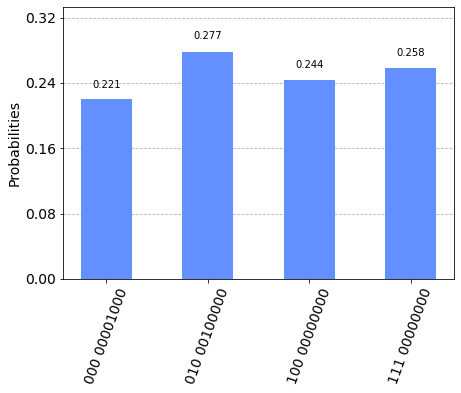

In [218]:
c = ClassicalRegister(8, 'measure')
qram_measure = QuantumCircuit(c)
qc = qc_initQram + qram_measure
qc.measure(range(8), range(8))
qc = qc.reverse_bits()
job = execute(qc, backend_sim, shots=512)
result_job = job.result()
plot_histogram(result_job.get_counts())

Here we map our the attacks of our actual fighter and match which their type.

#### Switch <a class="anchor" id="switch"></a>
For the switch it's the exact same thing, but we have to map all of our pokemon on X qubits and all of their attacks type. For a team of 3 pokemons, we map the pokemon on the first qubit and the attack on the 2 next.

#### Choose action <a class="anchor" id="choose"></a>
At the beginning of the tour, the quantum computer have to choose if it has to do an attack or to switch of Pokemon. To make this choice, we map the actual fighter of the opponent and see if its type is a weakness of ours. If yes, the quantum computer will choose to switch Pokemon, else it'll choose to attacks.

Now we know how to create our quantum structure, how to map our inputs and know the design of our oracle (the graph one). Let glue each part together.

### General algorythm <a class="anchor" id="algorythm"></a>
The main algorithm is the mapping algorithm and we'll use it to find the best attack move, finding the best switching to another fight and to help the computer to choose if it has to attack or switch if its actual fighter is in danger. To make an example, we want our computer to do is finding the best move.
To do that we need :
- first -> give to our circuit the type of the moves our fighter knows. Lucky us we did it in the upper example ;)
- second -> map the weikness and resistance of the opposent fighter
- third -> mixing weikness and resistance together to know each move are very strong or not
- last -> adding the grover diffuser

Let imagine, the computer fighter is a Blastoise and ours is a Charamender.
<br/>Charamender is a fire/fly type Pokemon so its weikness will be :
- water
- ground
- electrick
- ice

And its resistances :
- fire
- bug
- grass
- steel
- ice
<br/>Also the fly type has an immunity to the ground type, means the fly type Pokemon would never take any damage from a ground move.
- ground --> immunity

First of all, we have to map all of these parameters :

In [219]:
# Init type qubits
fire_q = QuantumRegister(1, 'fire')
grass_q = QuantumRegister(1, 'grass')
ground_q = QuantumRegister(1, 'ground')
fly_q = QuantumRegister(1, 'fly')
water_q = QuantumRegister(1, 'water')
elec_q = QuantumRegister(1, 'electrick')
ice_q = QuantumRegister(1, 'ice')
bug_q = QuantumRegister(1, 'bug')
steel_q = QuantumRegister(1, 'steel')
qc_types = QuantumCircuit(fire_q, grass_q, ground_q, fly_q, water_q, elec_q, ice_q, bug_q, steel_q)

# Init charamender
fire_weak = [water_q, ground_q]
fly_weak = [elec_q, ice_q]
fire_resist = [fire_q, bug_q, grass_q, steel_q, ice_q]
fly_resist = [grass_q, bug_q]
fire_immune = ["None"]
fly_immune = [ground_q]

# Charamenter type map
weakFire_q = QuantumRegister(1, 'weak_fire')
weakFly_q = QuantumRegister(1, 'weak_fly')
checkWeak_q = QuantumRegister(1, 'check_weak')

resistFire_q = QuantumRegister(1, 'resist_fire')
resistFly_q = QuantumRegister(1, 'resist_fly')
immuneFire_q = QuantumRegister(1, 'immunity_fire')
immuneFly_q = QuantumRegister(1, 'immunity_fly')
qc_charamender = QuantumCircuit(weakFire_q, weakFly_q, checkWeak_q, resistFire_q, resistFly_q, immuneFire_q, immuneFly_q)

qc_defenderMapping = qc_types + qc_charamender

# Apply gates
## Weakness
if fire_weak[0] != "None":
    for i in fire_weak:
        qc_defenderMapping.cx(i, weakFire_q)
if fly_weak[0] != "None":
    for i in fly_weak:
        qc_defenderMapping.cx(i, weakFly_q)
qc_defenderMapping.barrier()
## Resistances
if fire_resist[0] != "None":
    for i in fire_resist:
        qc_defenderMapping.cx(i, resistFire_q)
if fly_resist[0] != "None":
    for i in fly_resist:
        qc_defenderMapping.cx(i, resistFly_q)
qc_defenderMapping.barrier()
## Immunity
if fire_immune[0] != "None":
    for i in fire_immune:
        qc_defenderMapping.cx(i, immuneFire_q)
if fly_immune[0] != "None":
    for i in fly_immune:
        qc_defenderMapping.cx(i, immuneFly_q)

# Check of the weakness
def or_weak(qc):
    qc.barrier()
    qc.cx(weakFire_q[0], checkWeak_q[0])
    qc.cx(weakFly_q[0], checkWeak_q[0])
    qc.ccx(weakFly_q[0], weakFire_q[0], checkWeak_q[0])
    qc.barrier()
qc_orweak = qc_types + qc_charamender

or_weak(qc_orweak)

(qc_defenderMapping + qc_orweak).draw()

░                                     ░ »
         fire_0: ─────────────────────░───■─────────────────────────────────░─»
                                      ░   │                                 ░ »
        grass_0: ─────────────────────░───┼─────────■─────────■─────────────░─»
                                      ░   │         │         │             ░ »
       ground_0: ────────────■────────░───┼─────────┼─────────┼─────────────░─»
                             │        ░   │         │         │             ░ »
          fly_0: ────────────┼────────░───┼─────────┼─────────┼─────────────░─»
                             │        ░   │         │         │             ░ »
        water_0: ──■─────────┼────────░───┼─────────┼─────────┼─────────────░─»
                   │         │        ░   │         │         │             ░ »
    electrick_0: ──┼────■────┼────────░───┼─────────┼─────────┼─────────────░─»
                   │    │    │        ░   │         │         │             ░ »
          ice_0: ──┼────┼────┼────■───░───┼─────────┼─────────┼────■────────░─»
                   │    │    │    │   ░   │         │         │    │        ░ »
          bug_0: ──┼────┼────┼────┼───░───┼────■────┼─────────┼────┼────■───░─»
                   │    │    │    │   ░   │    │    │         │    │    │   ░ »
        steel_0: ──┼────┼────┼────┼───░───┼────┼────┼────■────┼────┼────┼───░─»
                 ┌─┴─┐  │  ┌─┴─┐  │   ░   │    │    │    │    │    │    │   ░ »
    weak_fire_0: ┤ X ├──┼──┤ X ├──┼───░───┼────┼────┼────┼────┼────┼────┼───░─»
                 └───┘┌─┴─┐└───┘┌─┴─┐ ░   │    │    │    │    │    │    │   ░ »
     weak_fly_0: ─────┤ X ├─────┤ X ├─░───┼────┼────┼────┼────┼────┼────┼───░─»
                      └───┘     └───┘ ░   │    │    │    │    │    │    │   ░ »
   check_weak_0: ─────────────────────░───┼────┼────┼────┼────┼────┼────┼───░─»
                                      ░ ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐  │  ┌─┴─┐  │   ░ »
  resist_fire_0: ─────────────────────░─┤ X ├┤ X ├┤ X ├┤ X ├──┼──┤ X ├──┼───░─»
                                      ░ └───┘└───┘└───┘└───┘┌─┴─┐└───┘┌─┴─┐ ░ »
   resist_fly_0: ─────────────────────░─────────────────────┤ X ├─────┤ X ├─░─»
                                      ░                     └───┘     └───┘ ░ »
immunity_fire_0: ─────────────────────░─────────────────────────────────────░─»
                                      ░                                     ░ »
 immunity_fly_0: ─────────────────────░─────────────────────────────────────░─»
                                      ░                                     ░ »
«                       ░                 ░ 
«         fire_0: ──────░─────────────────░─
«                       ░                 ░ 
«        grass_0: ──────░─────────────────░─
«                       ░                 ░ 
«       ground_0: ──■───░─────────────────░─
«                   │   ░                 ░ 
«          fly_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«        water_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«    electrick_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«          ice_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«          bug_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«        steel_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«    weak_fire_0: ──┼───░───■─────────■───░─
«                   │   ░   │         │   ░ 
«     weak_fly_0: ──┼───░───┼────■────■───░─
«                   │   ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ 
«   check_weak_0: ──┼───░─┤ X ├┤ X ├┤ X ├─░─
«                   │   ░ └───┘└───┘└───┘ ░ 
«  resist_fire_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«   resist_fly_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«immunity_fire_0: ──┼───░─────────────────░─
«                 ┌─┴─┐ ░                 ░ 
« i

Here is the entire mapping for all the Charamender parameters, the check weakness qubit is using to synthetis if the move can be super effective or not. Now let's add the attack mapping. 

In [220]:
qc_algo = qc_init + qc_qram + qc_defenderMapping + qc_orweak

qc_algo.draw()

┌───┐┌───┐     ┌───┐ ░ ┌───┐     ┌───┐ ░                 ░ »
         qram_0: ┤ H ├┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├─░────────■────────░─»
                 ├───┤├───┤  │  ├───┤ ░ └───┘  │  └───┘ ░ ┌───┐  │  ┌───┐ ░ »
         qram_1: ┤ H ├┤ X ├──■──┤ X ├─░────────■────────░─┤ X ├──■──┤ X ├─░─»
                 └───┘└───┘  │  └───┘ ░        │        ░ └───┘  │  └───┘ ░ »
       normal_0: ────────────┼────────░────────┼────────░────────┼────────░─»
                             │        ░        │        ░        │        ░ »
         fire_0: ────────────┼────────░────────┼────────░────────┼────────░─»
                             │        ░        │        ░        │        ░ »
        grass_0: ────────────┼────────░────────┼────────░────────┼────────░─»
                             │        ░      ┌─┴─┐      ░        │        ░ »
       ground_0: ────────────┼────────░──────┤ X ├──────░────────┼────────░─»
                             │        ░      └───┘      ░        │        ░ »
          fly_0: ────────────┼────────░─────────────────░────────┼────────░─»
                           ┌─┴─┐      ░                 ░        │        ░ »
        water_0: ──────────┤ X ├──────░─────────────────░────────┼────────░─»
                           └───┘      ░                 ░        │        ░ »
    electrick_0: ─────────────────────░─────────────────░────────┼────────░─»
                                      ░                 ░      ┌─┴─┐      ░ »
          ice_0: ─────────────────────░─────────────────░──────┤ X ├──────░─»
                                      ░                 ░      └───┘      ░ »
          bug_0: ─────────────────────░─────────────────░─────────────────░─»
                                      ░                 ░                 ░ »
        steel_0: ─────────────────────░─────────────────░─────────────────░─»
                                      ░                 ░                 ░ »
    weak_fire_0: ───────────────────────────────────────────────────────────»
                                                                            »
     weak_fly_0: ───────────────────────────────────────────────────────────»
                                                                            »
   check_weak_0: ───────────────────────────────────────────────────────────»
                                                                            »
  resist_fire_0: ───────────────────────────────────────────────────────────»
                                                                            »
   resist_fly_0: ───────────────────────────────────────────────────────────»
                                                                            »
immunity_fire_0: ───────────────────────────────────────────────────────────»
                                                                            »
 immunity_fly_0: ───────────────────────────────────────────────────────────»
                                                                            »
  measurement: 3/═══════════════════════════════════════════════════════════»
                                                                            »
«                       ░                                                      »
«         qram_0: ──■───░──────────────────────────────────────────────────────»
«                   │   ░                                                      »
«         qram_1: ──■───░──────────────────────────────────────────────────────»
«                 ┌─┴─┐ ░                                                      »
«       normal_0: ┤ X ├─░──────────────────────────────────────────────────────»
«                 └───┘ ░                      ░                               »
«         fire_0: ──────░──────────────────────░───■───────────────────────────»
«                       ░                      ░   │                           »
«        grass_0: ──────░──────────────────────░───┼─────────■─────────■───────»
«        

Now we have to indicate to our oracle when the requirement for an input to be a correct answer. For that we will use an CNOT gate on the check qubits, both resist qubits and both immune qubits :
- the check qubit indicate if a move is very strong or not again the target
- the resist qubit is on 0 and stay on 0 if the move is strong or very strong
- the immune qubit stay on 0 if the move can make domage to the target

For the resistances qubits and the immune qubits we will around them by a X gate to make sure they staied on 0.

In [221]:
oracle_q = QuantumRegister(1, 'oracle')
qc_oracle = QuantumCircuit(oracle_q)
qc_oracle.x(oracle_q)
qc_oracle.h(oracle_q)

# Glueing everything together
qc_finale = qc_oracle + qc_init + qc_qram + qc_defenderMapping + qc_orweak

qc_finale.x([resistFire_q[0], resistFly_q[0], immuneFire_q[0], immuneFly_q[0]])
qc_finale.mcx([checkWeak_q, resistFire_q, resistFly_q, immuneFire_q, immuneFly_q], oracle_q)
qc_finale.x([resistFire_q[0], resistFly_q[0], immuneFire_q[0], immuneFly_q[0]])
qc_finale.barrier()

qc_finale.draw()

┌───┐┌───┐                                                 »
       oracle_0: ┤ X ├┤ H ├─────────────────────────────────────────────────»
                 ├───┤├───┤     ┌───┐ ░ ┌───┐     ┌───┐ ░                 ░ »
         qram_0: ┤ H ├┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├─░────────■────────░─»
                 ├───┤├───┤  │  ├───┤ ░ └───┘  │  └───┘ ░ ┌───┐  │  ┌───┐ ░ »
         qram_1: ┤ H ├┤ X ├──■──┤ X ├─░────────■────────░─┤ X ├──■──┤ X ├─░─»
                 └───┘└───┘  │  └───┘ ░        │        ░ └───┘  │  └───┘ ░ »
       normal_0: ────────────┼────────░────────┼────────░────────┼────────░─»
                             │        ░        │        ░        │        ░ »
         fire_0: ────────────┼────────░────────┼────────░────────┼────────░─»
                             │        ░        │        ░        │        ░ »
        grass_0: ────────────┼────────░────────┼────────░────────┼────────░─»
                             │        ░      ┌─┴─┐      ░        │        ░ »
       ground_0: ────────────┼────────░──────┤ X ├──────░────────┼────────░─»
                             │        ░      └───┘      ░        │        ░ »
          fly_0: ────────────┼────────░─────────────────░────────┼────────░─»
                           ┌─┴─┐      ░                 ░        │        ░ »
        water_0: ──────────┤ X ├──────░─────────────────░────────┼────────░─»
                           └───┘      ░                 ░        │        ░ »
    electrick_0: ─────────────────────░─────────────────░────────┼────────░─»
                                      ░                 ░      ┌─┴─┐      ░ »
          ice_0: ─────────────────────░─────────────────░──────┤ X ├──────░─»
                                      ░                 ░      └───┘      ░ »
          bug_0: ─────────────────────░─────────────────░─────────────────░─»
                                      ░                 ░                 ░ »
        steel_0: ─────────────────────░─────────────────░─────────────────░─»
                                      ░                 ░                 ░ »
    weak_fire_0: ───────────────────────────────────────────────────────────»
                                                                            »
     weak_fly_0: ───────────────────────────────────────────────────────────»
                                                                            »
   check_weak_0: ───────────────────────────────────────────────────────────»
                                                                            »
  resist_fire_0: ───────────────────────────────────────────────────────────»
                                                                            »
   resist_fly_0: ───────────────────────────────────────────────────────────»
                                                                            »
immunity_fire_0: ───────────────────────────────────────────────────────────»
                                                                            »
 immunity_fly_0: ───────────────────────────────────────────────────────────»
                                                                            »
  measurement: 3/═══════════════════════════════════════════════════════════»
                                                                            »
«                                                                              »
«       oracle_0: ─────────────────────────────────────────────────────────────»
«                       ░                                                      »
«         qram_0: ──■───░──────────────────────────────────────────────────────»
«                   │   ░                                                      »
«         qram_1: ──■───░──────────────────────────────────────────────────────»
«                 ┌─┴─┐ ░                                                      »
«       normal_0: ┤ X ├─░──────────────────────────────────────────────────────»
«              

Now our entire algo is finished, in order to not have error in the distribution we need to play the entire algorithm a second time (not the oracle part) to uncompute the whole every transformation. And finally we just need to apply our diffuser and some measurement and we could see the result.

In [222]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)
    qc.h(nqubits - 1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return qc


qc_finale = qc_oracle + qc_init 
for i in range(1):
    qc_finale = qc_finale + qc_qram + qc_defenderMapping + qc_orweak

    qc_finale.x([resistFire_q[0], resistFly_q[0], immuneFire_q[0], immuneFly_q[0]])
    qc_finale.mcx([checkWeak_q, resistFire_q, resistFly_q, immuneFire_q, immuneFly_q], oracle_q)
    qc_finale.x([resistFire_q[0], resistFly_q[0], immuneFire_q[0], immuneFly_q[0]])

    qc_finale = qc_finale + qc_orweak + qc_defenderMapping + qc_qram

    qc_finale.append(diffuser(2), [1, 2])
    
qc_finale.barrier()
qc_finale.measure(qram_q, range(2))

qc_finale.draw()

┌───┐┌───┐                                                 »
       oracle_0: ┤ X ├┤ H ├─────────────────────────────────────────────────»
                 ├───┤├───┤     ┌───┐ ░ ┌───┐     ┌───┐ ░                 ░ »
         qram_0: ┤ H ├┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├─░────────■────────░─»
                 ├───┤├───┤  │  ├───┤ ░ └───┘  │  └───┘ ░ ┌───┐  │  ┌───┐ ░ »
         qram_1: ┤ H ├┤ X ├──■──┤ X ├─░────────■────────░─┤ X ├──■──┤ X ├─░─»
                 └───┘└───┘  │  └───┘ ░        │        ░ └───┘  │  └───┘ ░ »
       normal_0: ────────────┼────────░────────┼────────░────────┼────────░─»
                             │        ░        │        ░        │        ░ »
         fire_0: ────────────┼────────░────────┼────────░────────┼────────░─»
                             │        ░        │        ░        │        ░ »
        grass_0: ────────────┼────────░────────┼────────░────────┼────────░─»
                             │        ░      ┌─┴─┐      ░        │        ░ »
       ground_0: ────────────┼────────░──────┤ X ├──────░────────┼────────░─»
                             │        ░      └───┘      ░        │        ░ »
          fly_0: ────────────┼────────░─────────────────░────────┼────────░─»
                           ┌─┴─┐      ░                 ░        │        ░ »
        water_0: ──────────┤ X ├──────░─────────────────░────────┼────────░─»
                           └───┘      ░                 ░        │        ░ »
    electrick_0: ─────────────────────░─────────────────░────────┼────────░─»
                                      ░                 ░      ┌─┴─┐      ░ »
          ice_0: ─────────────────────░─────────────────░──────┤ X ├──────░─»
                                      ░                 ░      └───┘      ░ »
          bug_0: ─────────────────────░─────────────────░─────────────────░─»
                                      ░                 ░                 ░ »
        steel_0: ─────────────────────░─────────────────░─────────────────░─»
                                      ░                 ░                 ░ »
    weak_fire_0: ───────────────────────────────────────────────────────────»
                                                                            »
     weak_fly_0: ───────────────────────────────────────────────────────────»
                                                                            »
   check_weak_0: ───────────────────────────────────────────────────────────»
                                                                            »
  resist_fire_0: ───────────────────────────────────────────────────────────»
                                                                            »
   resist_fly_0: ───────────────────────────────────────────────────────────»
                                                                            »
immunity_fire_0: ───────────────────────────────────────────────────────────»
                                                                            »
 immunity_fly_0: ───────────────────────────────────────────────────────────»
                                                                            »
  measurement: 3/═══════════════════════════════════════════════════════════»
                                                                            »
«                                                                              »
«       oracle_0: ─────────────────────────────────────────────────────────────»
«                       ░ ┌───┐                                                »
«         qram_0: ──■───░─┤ X ├────────────────────────────────────────────────»
«                   │   ░ ├───┤                                                »
«         qram_1: ──■───░─┤ X ├────────────────────────────────────────────────»
«                 ┌─┴─┐ ░ └───┘                                                »
«       normal_0: ┤ X ├─░──────────────────────────────────────────────────────»
«              

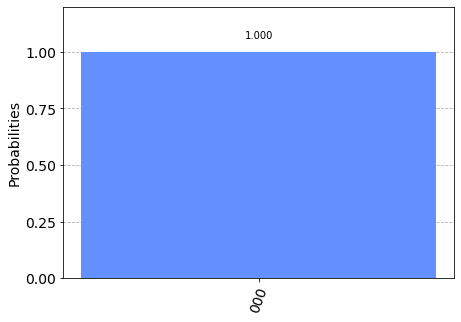

In [223]:
qc = qc_finale.reverse_bits()
job = execute(qc, backend_sim, shots=512)
result_job = job.result()
plot_histogram(result_job.get_counts())

As we can see the only answer are the attack on the address 00 who is hydroblast a water attack, one of the weakness of Charamender. That's exactly what we wanted for our output.
<br/>To resume the global structure of the circuit is looking like this :

In [224]:
oracle_q = QuantumRegister(1, 'oracle')
qram_q = QuantumRegister(2, 'qram')

fire_q = QuantumRegister(1, 'fire')
grass_q = QuantumRegister(1, 'grass')
ground_q = QuantumRegister(1, 'ground')
fly_q = QuantumRegister(1, 'fly')
water_q = QuantumRegister(1, 'water')
elec_q = QuantumRegister(1, 'electrick')
ice_q = QuantumRegister(1, 'ice')
bug_q = QuantumRegister(1, 'bug')
steel_q = QuantumRegister(1, 'steel')
normal_q = QuantumRegister(1, 'normal')

resistFire_q = QuantumRegister(1, 'resist_fire')
resistFly_q = QuantumRegister(1, 'resist_fly')
immuneFire_q = QuantumRegister(1, 'immunity_fire')
immuneFly_q = QuantumRegister(1, 'immunity_fly')
weakFire_q = QuantumRegister(1, 'weak_fire')
weakFly_q = QuantumRegister(1, 'weak_fly')
checkWeak_q = QuantumRegister(1, 'check_weak')

c = ClassicalRegister(2, 'measure')

qc = QuantumCircuit(oracle_q, qram_q, fire_q, grass_q, ground_q, fly_q, water_q, elec_q, ice_q, bug_q, 
                    steel_q, normal_q, resistFire_q, resistFly_q, immuneFire_q, immuneFly_q, 
                    weakFire_q, weakFly_q, checkWeak_q, c)

def qram(nqubits):
    qc = QuantumCircuit(nqubits)
    U_s = qc.to_gate()
    U_s.name = "$QRAM$"
    return U_s

def defenderMapping(nqubits):
    qc = QuantumCircuit(nqubits)
    U_s = qc.to_gate()
    U_s.name = "$mappingChara$"
    return U_s

def orweak(nqubits):
    qc = QuantumCircuit(nqubits)
    U_s = qc.to_gate()
    U_s.name = "$weakCheck$"
    return U_s

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    U_s = qc.to_gate()
    U_s.name = "$diffuser$"
    return U_s

# Init
qc.x(oracle_q)
qc.h(oracle_q)
qc.h(qram_q)
qc.barrier()

for i in range(1):
    # Qram
    qc.append(qram(12), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    # Algo
    qc.append(defenderMapping(16), [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
    qc.append(orweak(3), [17, 18, 19])

    # Oracle
    qc.barrier()
    qc.x([resistFire_q[0], resistFly_q[0], immuneFire_q[0], immuneFly_q[0]])
    qc.mcx([checkWeak_q, resistFire_q, resistFly_q, immuneFire_q, immuneFly_q], oracle_q)
    qc.x([resistFire_q[0], resistFly_q[0], immuneFire_q[0], immuneFly_q[0]])
    qc.barrier()

    # Uncompute
    qc.append(orweak(3), [17, 18, 19])
    qc.append(defenderMapping(16), [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
    qc.append(qram(12), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

    # Diffuser
    qc.append(diffuser(2), [1, 2])
    
qc.barrier()
qc.measure(qram_q, range(2))

qc.draw()

┌───┐┌───┐ ░                                                 »
       oracle_0: ┤ X ├┤ H ├─░─────────────────────────────────────────────────»
                 ├───┤└───┘ ░ ┌──────────┐                                    »
         qram_0: ┤ H ├──────░─┤0         ├────────────────────────────────────»
                 ├───┤      ░ │          │                                    »
         qram_1: ┤ H ├──────░─┤1         ├────────────────────────────────────»
                 └───┘      ░ │          │┌──────────────────┐                »
         fire_0: ───────────░─┤2         ├┤0                 ├────────────────»
                            ░ │          ││                  │                »
        grass_0: ───────────░─┤3         ├┤1                 ├────────────────»
                            ░ │          ││                  │                »
       ground_0: ───────────░─┤4         ├┤2                 ├────────────────»
                            ░ │          ││                  │                »
          fly_0: ───────────░─┤5         ├┤3                 ├────────────────»
                            ░ │   $QRAM$ ││                  │                »
        water_0: ───────────░─┤6         ├┤4                 ├────────────────»
                            ░ │          ││                  │                »
    electrick_0: ───────────░─┤7         ├┤5                 ├────────────────»
                            ░ │          ││                  │                »
          ice_0: ───────────░─┤8         ├┤6                 ├────────────────»
                            ░ │          ││                  │                »
          bug_0: ───────────░─┤9         ├┤7                 ├────────────────»
                            ░ │          ││   $mappingChara$ │                »
        steel_0: ───────────░─┤10        ├┤8                 ├────────────────»
                            ░ │          ││                  │                »
       normal_0: ───────────░─┤11        ├┤9                 ├────────────────»
                            ░ └──────────┘│                  │                »
  resist_fire_0: ───────────░─────────────┤10                ├────────────────»
                            ░             │                  │                »
   resist_fly_0: ───────────░─────────────┤11                ├────────────────»
                            ░             │                  │                »
immunity_fire_0: ───────────░─────────────┤12                ├────────────────»
                            ░             │                  │                »
 immunity_fly_0: ───────────░─────────────┤13                ├────────────────»
                            ░             │                  │┌──────────────┐»
    weak_fire_0: ───────────░─────────────┤14                ├┤0             ├»
                            ░             │                  ││              │»
     weak_fly_0: ───────────░─────────────┤15                ├┤1 $weakCheck$ ├»
                            ░             └──────────────────┘│              │»
   check_weak_0: ───────────░─────────────────────────────────┤2             ├»
                            ░                                 └──────────────┘»
      measure: 2/═════════════════════════════════════════════════════════════»
                                                                              »
«                  ░      ┌───┐      ░                                     »
«       oracle_0: ─░──────┤ X ├──────░─────────────────────────────────────»
«                  ░      └─┬─┘      ░                                     »
«         qram_0: ─░────────┼────────░─────────────────────────────────────»
«                  ░        │        ░                                     »
«         qram_1: ─░────────┼────────░─────────────────────────────────────»
«                  ░        │        ░                 ┌──────────────────┐»
«         fire_0: ─░────────┼────────░

## And now ? <a class="anchor" id="then"></a>
Of course this program is not perfect at all, it only register 8 Pokemons and only attaq move (not status of stats move). But the main problem is the program doesn't have any graphic and should need at least a window with both pokemons players, attaq choose menu and life point.
Is you feel also that program is really need graphic or others cool features or improvements on the AI, do not hesitate and go to my [GitHub repository](https://github.com/mickahell/quantum_pokemon-fight) create some issue to I can grant you access and working together.

## References <a class="anchor" id="references"></a>
1. Qiskit Textbook [Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html)
2. Wikipedia, [Vertex cover](https://en.wikipedia.org/wiki/Vertex_cover)
3. [Graph Online](https://graphonline.ru/en/?graph=BipartiteGraph)
4. Quantum Pokemon Fight, [GitHub](https://github.com/mickahell/quantum_pokemon-fight)

## Author 
Michaël Rollin, [GitHub](https://github.com/mickahell), [Twitter](https://twitter.com/mickahell89700), [Linkedin](https://www.linkedin.com/in/michaelrollin/)